In [24]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from numpy.random import seed
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

In [2]:
data_filesT = glob.glob("../Tell1CalibCsvT/*.csv")

In [3]:
def module_names():
    names = []
    data = pd.read_csv(data_filesT[0] ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("low_threshold")]
    names = data[1]
    return names

In [4]:
map_data_path = "../module_mapping.csv"
map_data = pd.read_csv(map_data_path ,sep=' ', engine='python', index_col=False)
map_data_R = map_data[map_data["sensor_type"] == "R"].sort_values(by=['sensor_number'])
map_data_Phi = map_data[map_data["sensor_type"] == "phi"].sort_values(by=['sensor_number'])

r_sensors_numbers = map_data_R["sensor_number"][0:42].tolist()
phi_sensors_numbers = map_data_Phi["sensor_number"].tolist()

r_sensors_names = []
for i in r_sensors_numbers:
    r_sensors_names.append("VeloTELL1Board" + str(i))

phi_sensors_names = []
for i in phi_sensors_numbers:
    phi_sensors_names.append("VeloTELL1Board" + str(i))

In [5]:
def plot_history(train_loss):
    plt.figure(figsize=(15, 5))
#    ax = plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title("Train loss")

In [8]:
ncol   = 84
inputS = (ncol,)
modelRelu  = Sequential()

# Encoder Layers
modelRelu.add(Dense(40, activation = 'relu', input_shape=inputS))
modelRelu.add(Dense(10, activation = 'relu'))
modelRelu.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelRelu.add(Dense(10, activation = 'relu'))
modelRelu.add(Dense(40, activation = 'relu'))
modelRelu.add(Dense(84, activation = 'sigmoid'))

# Compile the Model
modelRelu.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelRelu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_9 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_10 (Dense)             (None, 84)                3444      
Total params: 7,746
Trainable params: 7,746
Non-trainable params: 0
_________________________________________________________________


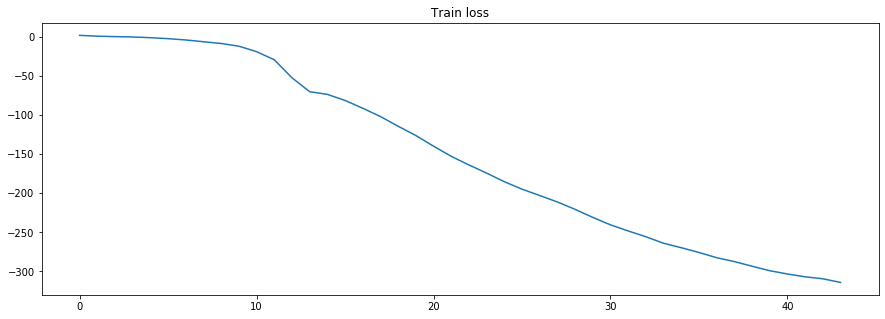

In [9]:
train_loss_batch = []

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data2 = data.loc[:, 2:2305]

    data2.index = module_names()
    data2.columns = range(2304)

    data_train = data2.T
    
    history = modelRelu.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [10]:
chanell_encoder = Model(modelRelu.input, modelRelu.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6_input (InputLayer)   (None, 84)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                3400      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                410       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 22        
Total params: 3,832
Trainable params: 3,832
Non-trainable params: 0
_________________________________________________________________


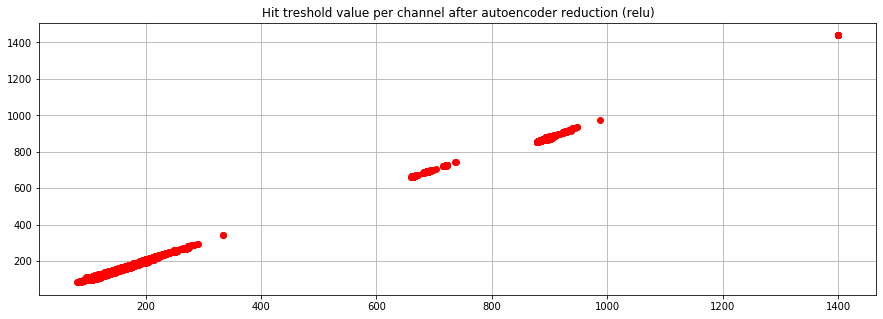

In [14]:
fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu)')

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data2 = data.loc[:, 2:2305]

    data2.index = module_names()
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [13]:
chanell_encoder.save('relu_channel_model_hit_treshold.h5')

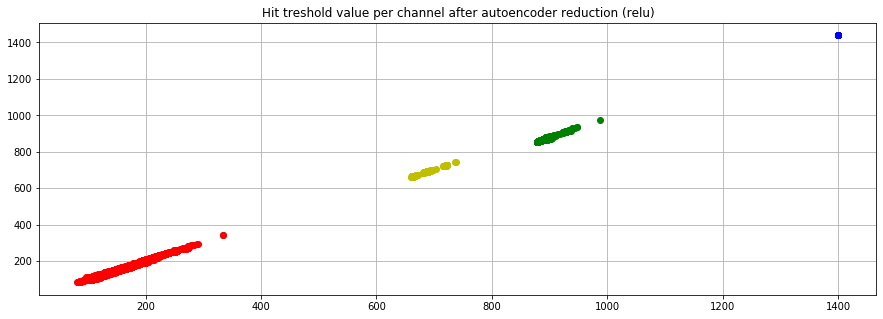

In [17]:
fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu)')

sensor_numbersR = []
sensor_numbersG = []
sensor_numbersB = []
sensor_numbersY = []

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data2 = data.loc[:, 2:2305]

    data2.index = module_names()
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    for i in data_test.index:
        if Zenc[i, 0] < 400:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'ro')
            sensor_numbersR.append(i)
        elif (Zenc[i, 0] > 600) and (Zenc[i, 0] < 800):
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'yo')
            sensor_numbersY.append(i)
        elif (Zenc[i, 0] > 800) and (Zenc[i, 0] < 1000):
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'go')
            sensor_numbersG.append(i)
        else:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'bo')
            sensor_numbersB.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [25]:
print("Red elements {:>27} {:>27} {:>27}".format("Blue elements", "Green elements", "Yellow elements"))
print("[channel number, amount] {:>26} {:>26} {:>26}".format("[channel number, amount]", "[channel number, amount]", "[channel number, amount]"))
snR = [[x,sensor_numbersR.count(x)] for x in set(sensor_numbersR)]
snG = [[x,sensor_numbersG.count(x)] for x in set(sensor_numbersG)]
snB = [[x,sensor_numbersB.count(x)] for x in set(sensor_numbersB)]
snY = [[x,sensor_numbersY.count(x)] for x in set(sensor_numbersY)]
maxR = len(snR)
maxG = len(snG)
maxB = len(snB)
maxY = len(snY)

for i in range(maxR):
    if i < maxG:
        print("[{:>14}, {:>6}]   [{:>14}, {:>6}]   [{:>14}, {:>6}]   [{:>14}, {:>6}]".format(snR[i][0], snR[i][1], snB[i][0], snB[i][1], snG[i][0], snG[i][1], snY[i][0], snY[i][1]))
    elif i >= maxG and i < maxB:
        print("[{:>14}, {:>6}]   [{:>14}, {:>6}]".format(snR[i][0], snR[i][1], snB[i][0], snB[i][1]))
    elif i >= maxB and i < (maxB + 10):
        print("[{:>14}, {:>6}]".format(snR[i][0], snR[i][1]))
print("[           ....       ]")      

Red elements               Blue elements              Green elements             Yellow elements
[channel number, amount]   [channel number, amount]   [channel number, amount]   [channel number, amount]
[             0,     44]   [           533,     44]   [           512,     44]   [           171,     44]
[             1,     44]   [           534,     44]   [           513,     44]   [           172,     44]
[             2,     44]   [           535,     44]   [           514,     44]   [           173,     44]
[             3,     44]   [           536,     44]   [           515,     44]   [           174,     44]
[             4,     44]   [           537,     44]   [           516,     44]   [           175,     44]
[             5,     44]   [           538,     44]   [           517,     44]   [           176,     44]
[             6,     44]   [           539,     44]   [           518,     44]   [           177,     44]
[             7,     44]   [           540,     44]   [

In [ ]:
barData = pd.DataFrame.from_records(snR)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Red cluster')  
ax.bar(barData[0], barData[1], color='r')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

In [ ]:
barData = pd.DataFrame.from_records(snY)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Yellow cluster')  
ax.bar(barData[0], barData[1], color='y')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

In [ ]:
barData = pd.DataFrame.from_records(snG)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Green cluster')  
ax.bar(barData[0], barData[1], color='g')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

In [ ]:
barData = pd.DataFrame.from_records(snB)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Blue cluster')  
ax.bar(barData[0], barData[1], color='b')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

In [16]:
ncol   = 42
inputS = (ncol,)
modelReluR = Sequential()

# Encoder Layers
modelReluR.add(Dense(20, activation = 'relu', input_shape=inputS))
modelReluR.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelReluR.add(Dense(20, activation = 'relu'))
modelReluR.add(Dense(42, activation = 'sigmoid'))

# Compile the Model
modelReluR.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelReluR.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 42)                882       
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


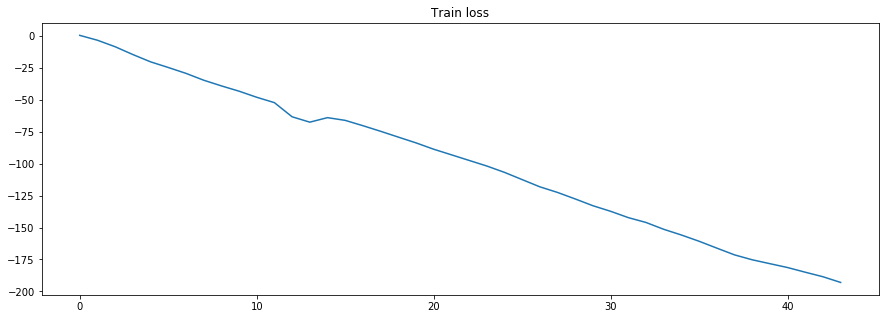

In [17]:
train_loss_batch = []

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_train = data2.T
    
    history = modelReluR.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [21]:
chanell_encoder = Model(modelReluR.input, modelReluR.get_layer('bottleneck').output)
chanell_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7_input (InputLayer)   (None, 42)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________


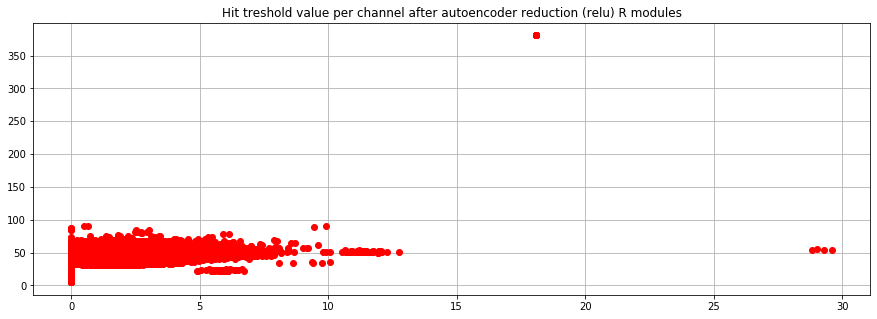

In [22]:
fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu) R modules')

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoder.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [20]:
chanell_encoder.save('relu_channel_model_hit_treshold_R_modules.h5')

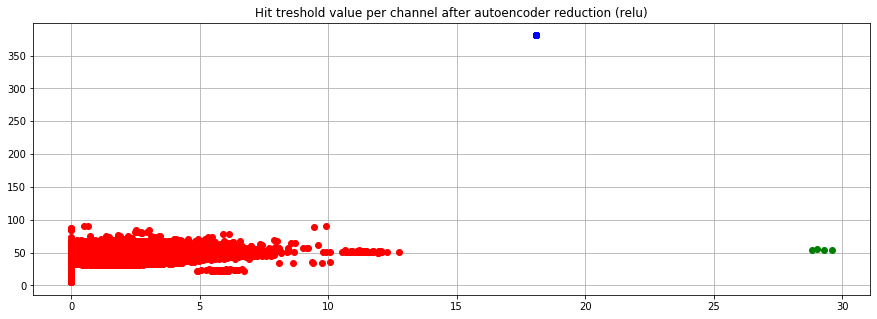

In [27]:
chanell_encoderS = load_model('relu_channel_model_hit_treshold_R_modules.h5')

sensor_numbersRR = []
sensor_numbersGG = []
sensor_numbersBB = []

fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu)')

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    for i in data_test.index:
        if Zenc[i, 0] < 15:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'ro')
            sensor_numbersRR.append(i)
        elif Zenc[i, 0] > 25:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'go')
            sensor_numbersGG.append(i)
        else:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'bo')
            sensor_numbersBB.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [33]:
snR = [[x,sensor_numbersRR.count(x)] for x in set(sensor_numbersRR)]
snB = [[x,sensor_numbersBB.count(x)] for x in set(sensor_numbersBB)]
snG = [[x,sensor_numbersGG.count(x)] for x in set(sensor_numbersGG)]

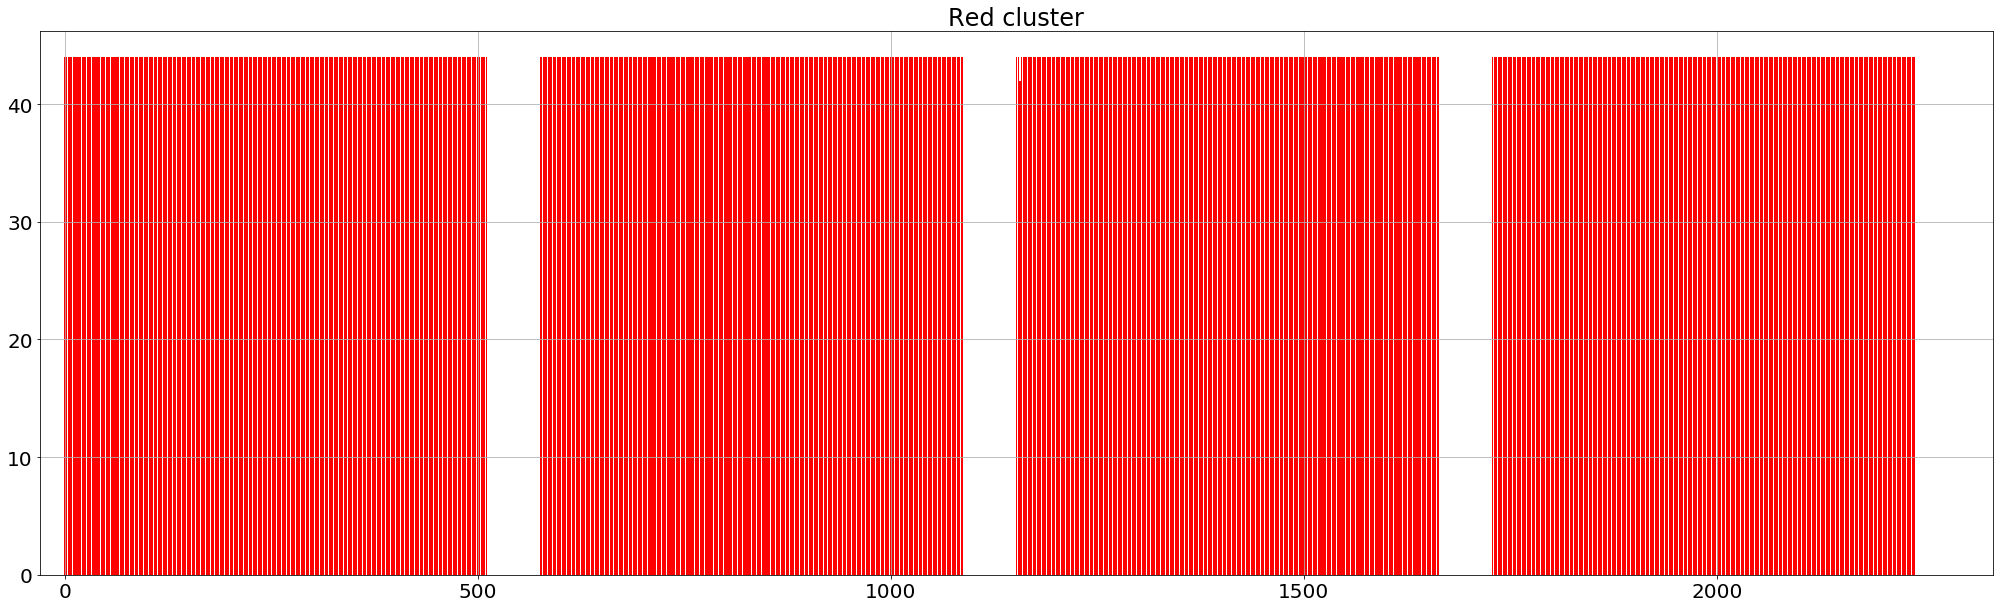

In [34]:
barData = pd.DataFrame.from_records(snR)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Red cluster')  
ax.bar(barData[0], barData[1], color='r')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

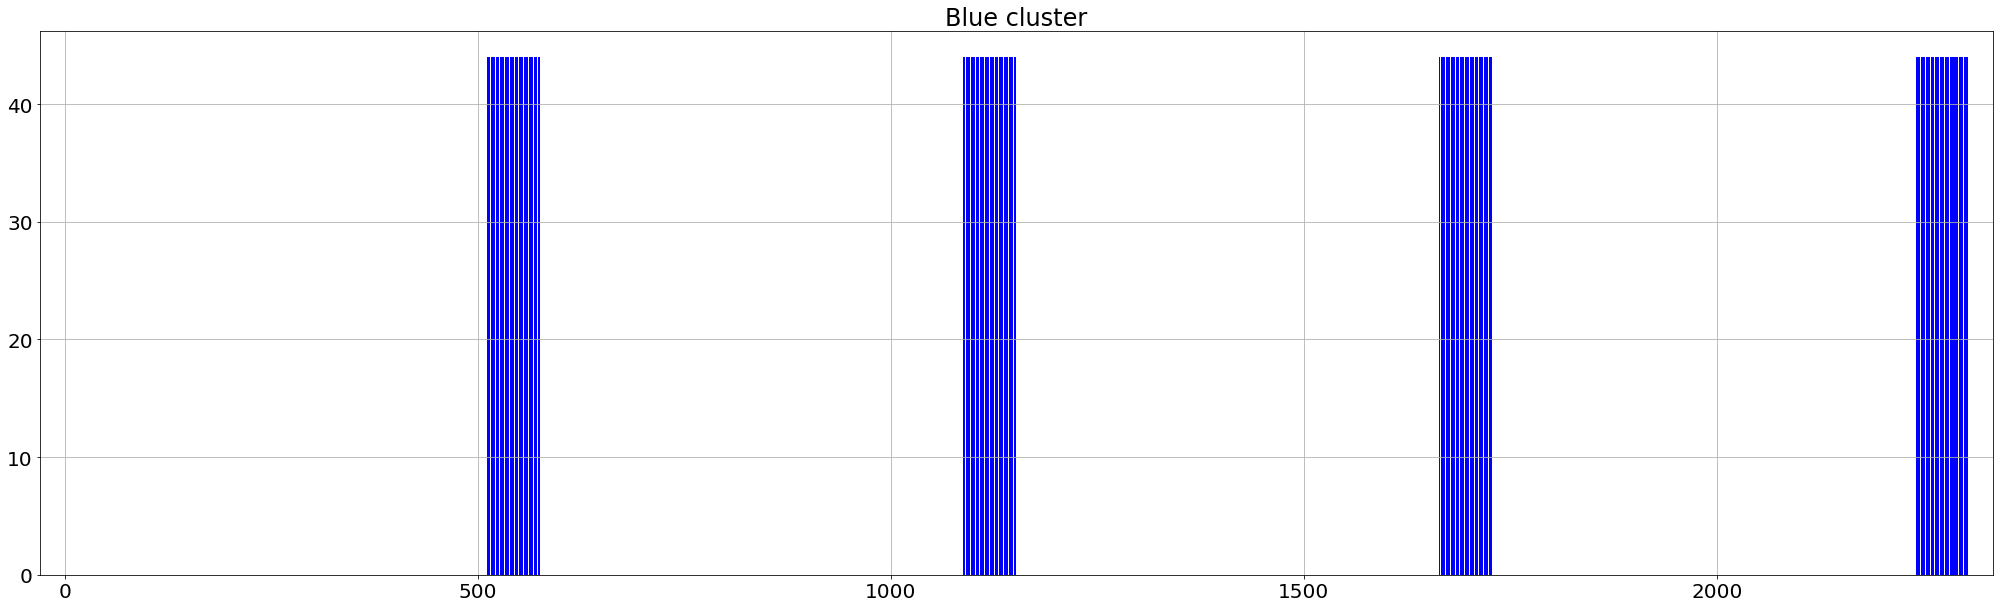

In [35]:
barData = pd.DataFrame.from_records(snB)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Blue cluster')  
ax.bar(barData[0], barData[1], color='b')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

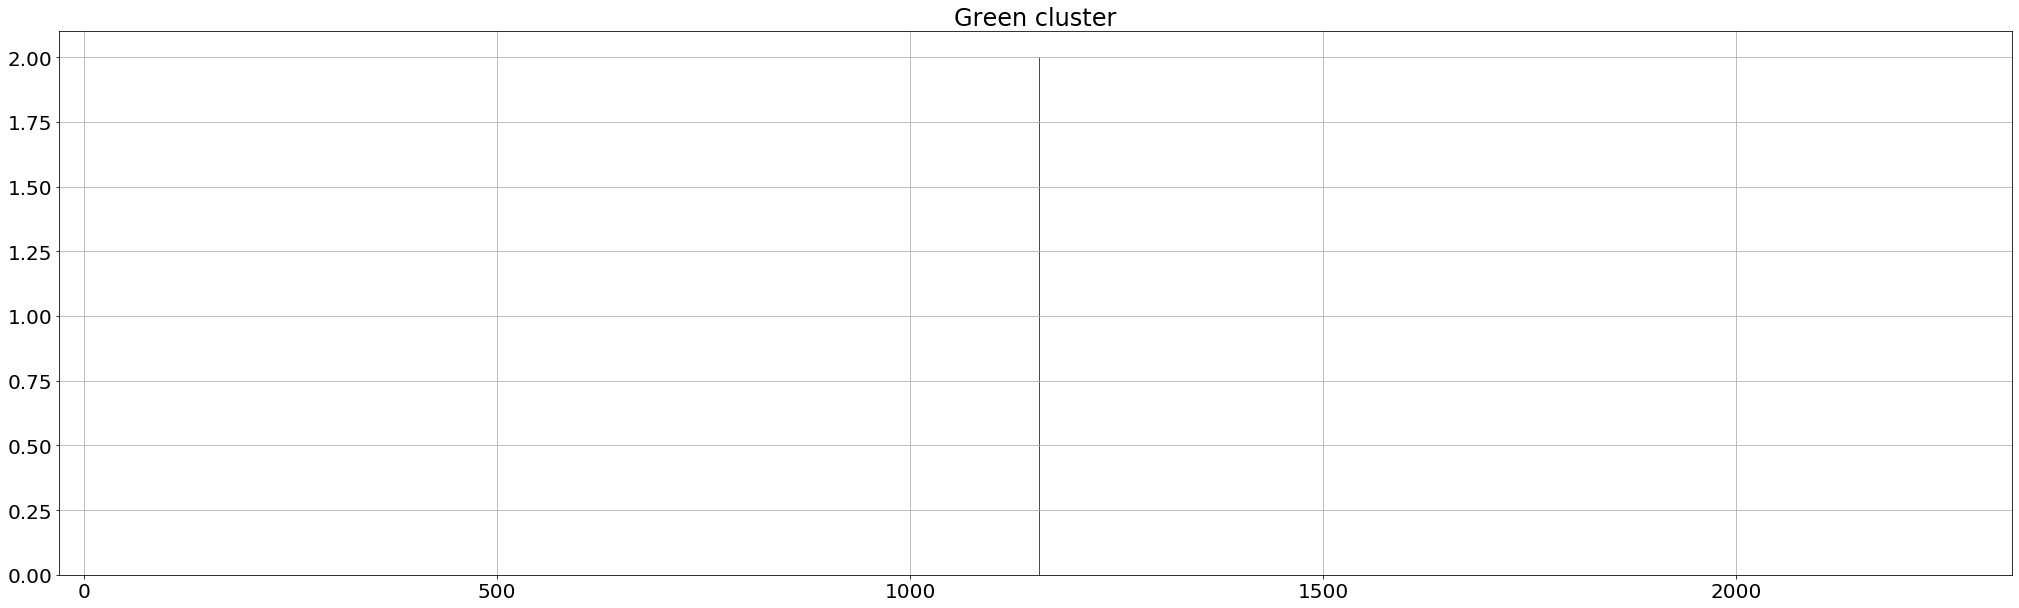

In [36]:
barData = pd.DataFrame.from_records(snG)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Green cluster')  
ax.bar(barData[0], barData[1], color='g')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

In [10]:
ncol   = 42
inputS = (ncol,)
modelReluPhi = Sequential()

# Encoder Layers
modelReluPhi.add(Dense(20, activation = 'relu', input_shape=inputS))
modelReluPhi.add(Dense(2,  activation = 'relu', name="bottleneck"))

# Decoder Layers
modelReluPhi.add(Dense(20, activation = 'relu'))
modelReluPhi.add(Dense(42, activation = 'sigmoid'))

# Compile the Model
modelReluPhi.compile(loss = 'binary_crossentropy', optimizer = Adam())

modelReluPhi.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_6 (Dense)              (None, 42)                882       
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


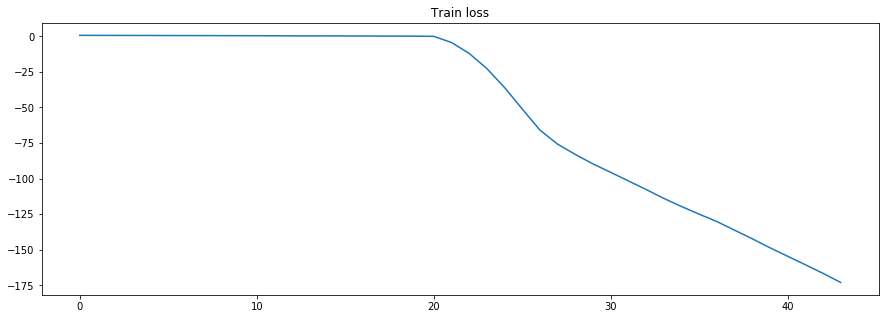

In [11]:
train_loss_batch = []

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(phi_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_train = data2.T
    
    history = modelReluPhi.train_on_batch(data_train, data_train)
    train_loss_batch.append(history)

#plot_history(train_loss_fit)
plot_history(train_loss_batch)

In [12]:
chanell_encoder2 = Model(modelReluPhi.input, modelReluPhi.get_layer('bottleneck').output)
chanell_encoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4_input (InputLayer)   (None, 42)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                860       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________


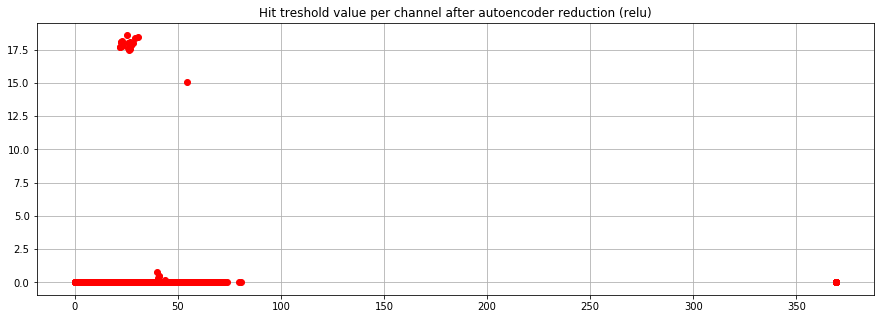

In [13]:
fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu)')

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(phi_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoder2.predict(data_test) 

    ax.plot(Zenc[:,0], Zenc[:,1], 'ro')
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [26]:
chanell_encoder2.save('relu_channel_model_hit_treshold_Phi_modules.h5')

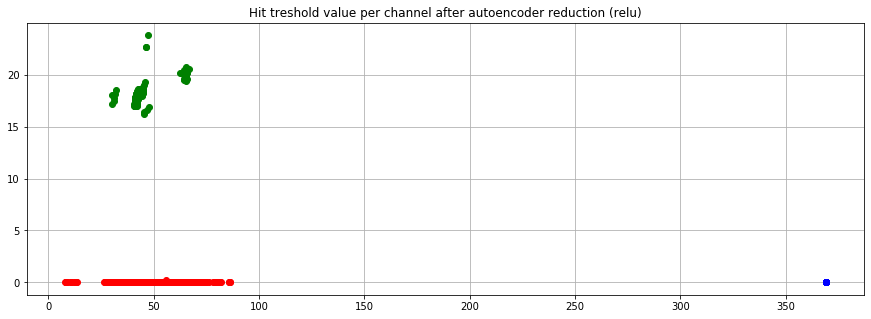

In [28]:
chanell_encoderS = load_model('relu_channel_model_hit_treshold_Phi_modules.h5')

sensor_numbersRRR = []
sensor_numbersGGG = []
sensor_numbersBBB = []

fig, ax = plt.subplots()
ax.set_title('Hit treshold value per channel after autoencoder reduction (relu)')

for file in data_filesT:
    data2 = pd.DataFrame()
    data = pd.read_csv(file ,sep=' ', header=None, engine='python', error_bad_lines=False, warn_bad_lines=False)
    data = data[data[0].str.contains("hit_threshold")]
    data.index = [i for i in range(84)]
    data = data[pd.DataFrame(data[1].tolist()).isin(r_sensors_names).any(1)]
    names = data[1].tolist()
    data2 = data.loc[:, 2:2305]

    data2.index = names
    data2.columns = range(2304)

    data_test = data2.T
    
    Zenc = chanell_encoderS.predict(data_test) 

    for i in data_test.index:
        if Zenc[i, 0] < 100:
            if Zenc[i, 1] < 5:
                ax.plot(Zenc[i, 0], Zenc[i, 1], 'ro')
                sensor_numbersRRR.append(i)
            else:
                ax.plot(Zenc[i, 0], Zenc[i, 1], 'go')
                sensor_numbersGGG.append(i)
        else:
            ax.plot(Zenc[i, 0], Zenc[i, 1], 'bo')
            sensor_numbersBBB.append(i)
    
#plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [15,5]
ax.grid()
plt.show()

In [29]:
snR = [[x,sensor_numbersRRR.count(x)] for x in set(sensor_numbersRRR)]
snB = [[x,sensor_numbersBBB.count(x)] for x in set(sensor_numbersBBB)]
snG = [[x,sensor_numbersGGG.count(x)] for x in set(sensor_numbersGGG)]

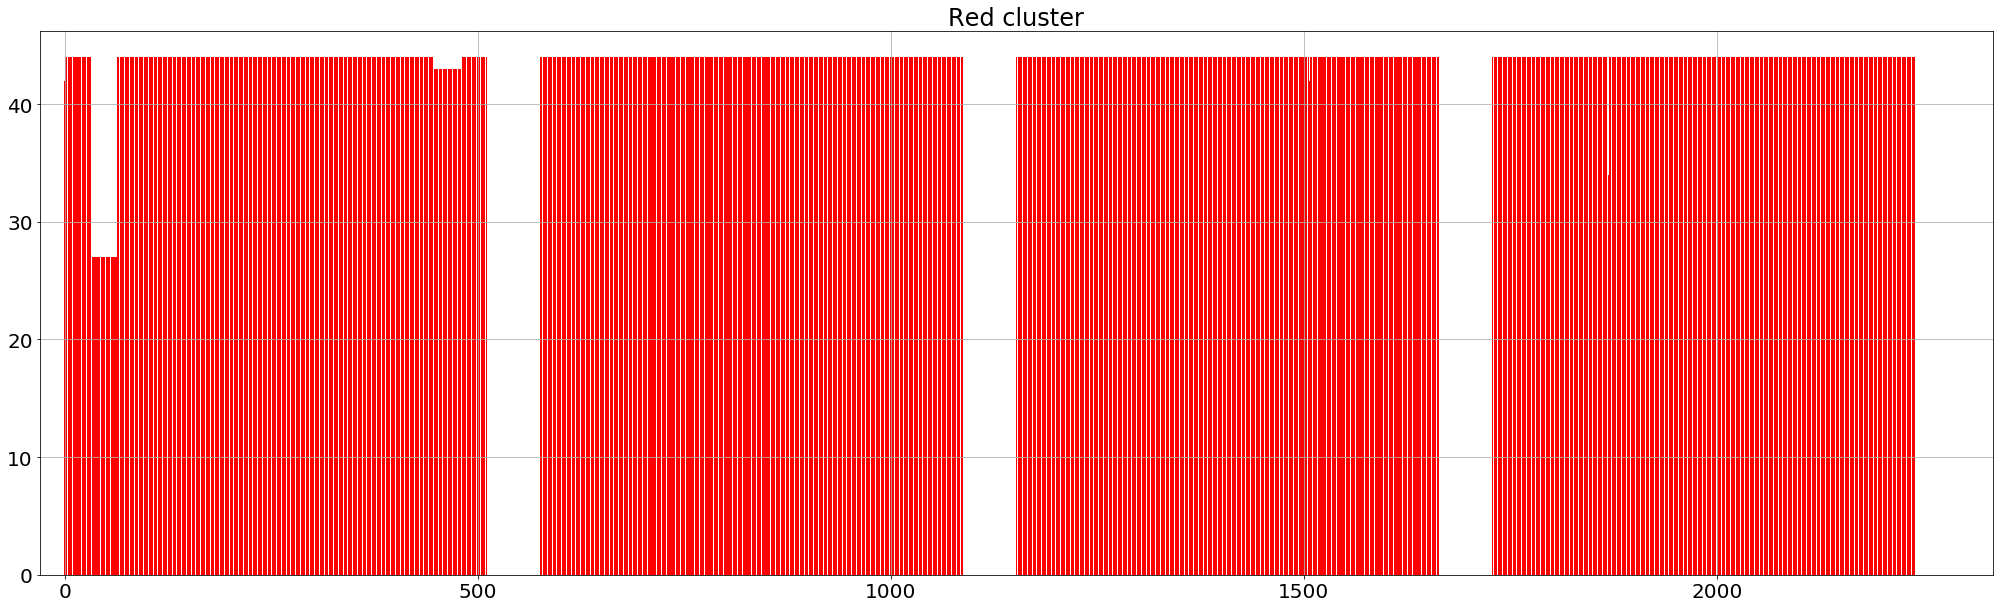

In [30]:
barData = pd.DataFrame.from_records(snR)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Red cluster')  
ax.bar(barData[0], barData[1], color='r')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

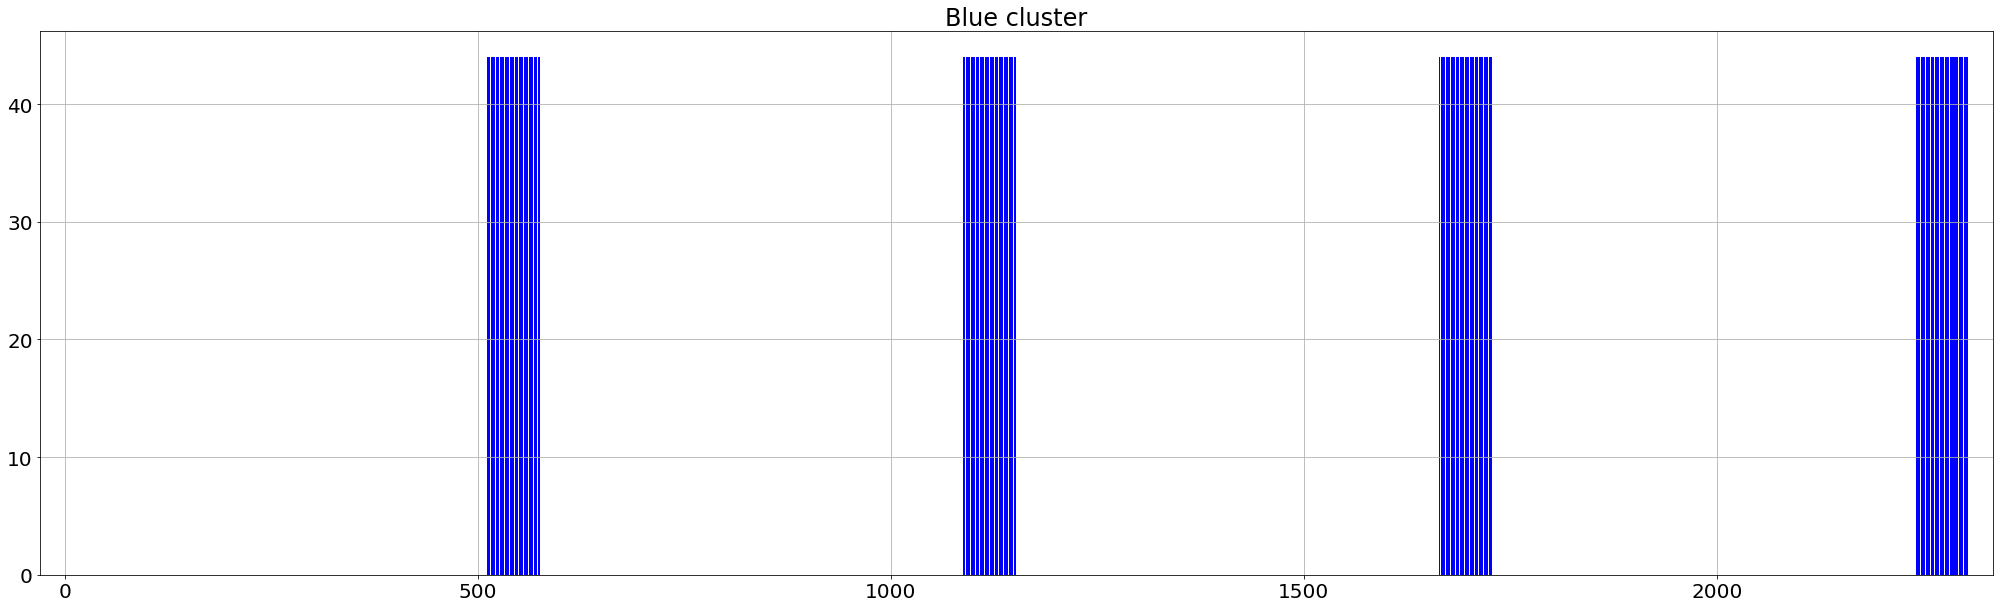

In [31]:
barData = pd.DataFrame.from_records(snB)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Blue cluster')  
ax.bar(barData[0], barData[1], color='b')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()

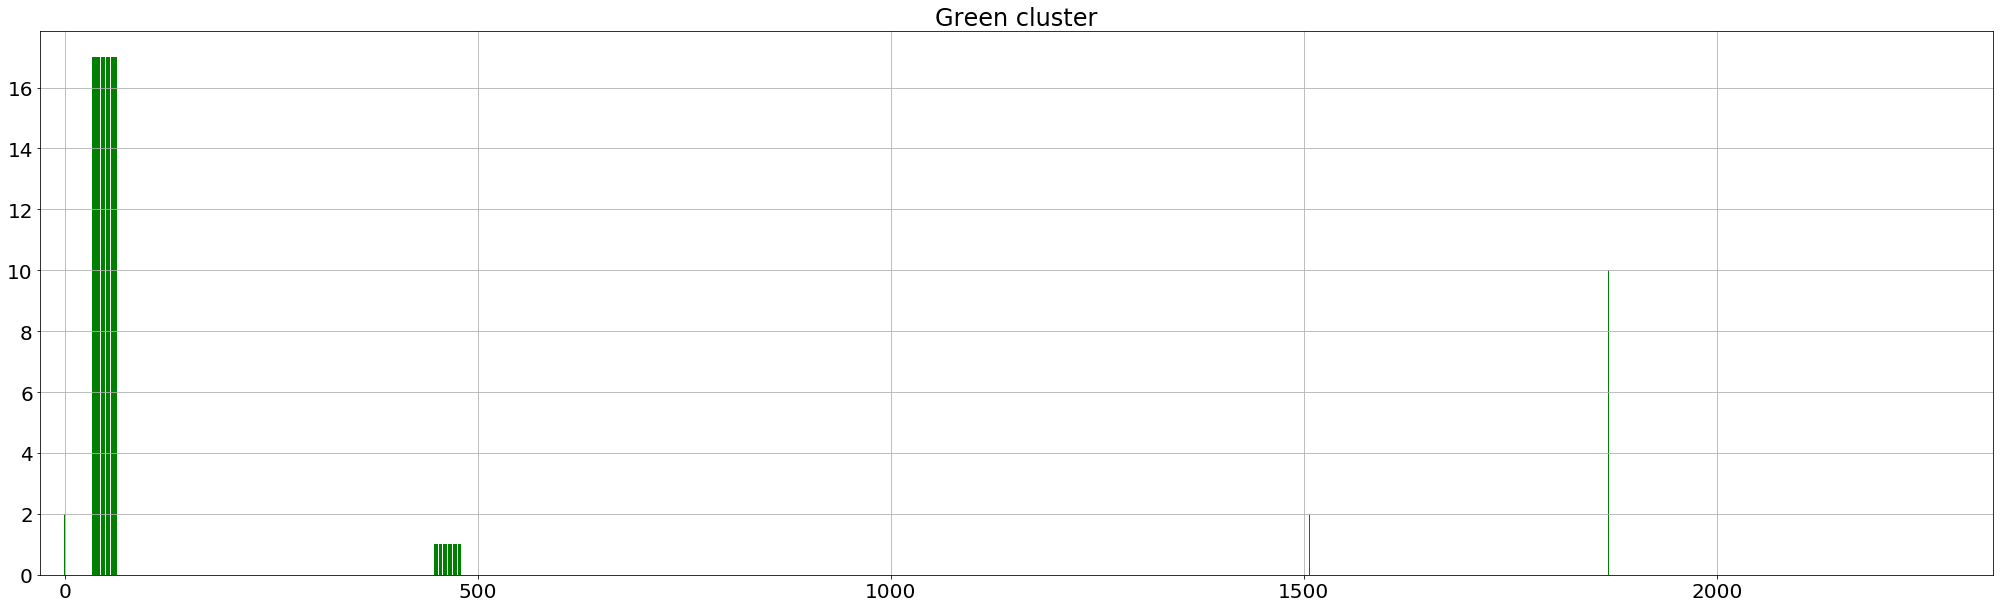

In [32]:
barData = pd.DataFrame.from_records(snG)

plt.rc('font', size=20)
plt.rcParams['figure.figsize'] = [35,10]
fig, ax = plt.subplots()

ax.set_title('Green cluster')  
ax.bar(barData[0], barData[1], color='g')
ax.set_xlim([-30, 2334])
ax.grid()

plt.show()